# PPO with MLP 

Getting some data:

In [4]:
import numpy as np
import yfinance as yf
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import math

In [6]:
tickers = ["AAPL","MSFT","GOOGL","META","AMZN","TSLA","NVDA"]

data = {}
for t in tickers:
    df = yf.download(t, start="2020-01-01", end="2023-01-01").copy()
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    # Features and their windows are the exact same as the supervised learning 
    # EMA (5‑day)
    ema = closes.ewm(span=5, adjust=False).mean().astype(np.float32)

    # RSI (14‑day)
    delta = closes.diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = -delta.clip(upper=0).rolling(14).mean()
    rs    = gain / loss
    rsi   = (100 - 100/(1 + rs)).astype(np.float32)

    # MACD (12‑26)
    ema12 = closes.ewm(span=12, adjust=False).mean()
    ema26 = closes.ewm(span=26, adjust=False).mean()
    macd  = (ema12 - ema26).astype(np.float32)

    # Bollinger Bands (20‑day)
    mbb    = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2*mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2*mbb_sd).astype(np.float32)

    data[t] = {
        "dates":      df.index,
        "raw":        closes.values,
        "norm":       norm.values,
        "ema":        ema.values,
        "rsi":        rsi.values,
        "macd":       macd.values,
        "bb_upper":   bb_upper.values,
        "bb_lower":   bb_lower.values,
    }

raw_prices =    {t: data[t]["raw"]      for t in tickers}
normalized_prices = {t: data[t]["norm"]      for t in tickers}

# dropping any Nan values
for t in tickers:
    # stacking feature columns to detect any NaNs per row
    feat_stack = np.column_stack([
        data[t]["norm"],
        data[t]["ema"],
        data[t]["rsi"],
        data[t]["macd"],
        data[t]["bb_upper"],
        data[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)

    data[t]["dates"]    = data[t]["dates"][start_idx:]
    data[t]["raw"]      = data[t]["raw"][start_idx:]
    data[t]["norm"]     = data[t]["norm"][start_idx:]
    data[t]["ema"]      = data[t]["ema"][start_idx:]
    data[t]["rsi"]      = data[t]["rsi"][start_idx:]
    data[t]["macd"]     = data[t]["macd"][start_idx:]
    data[t]["bb_upper"] = data[t]["bb_upper"][start_idx:]
    data[t]["bb_lower"] = data[t]["bb_lower"][start_idx:]


for t in tickers:
    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data[t][feat]
        mu, sigma = arr.mean(), arr.std()
        # overwrite with z‑score normalization
        data[t][feat] = (arr - mu) / sigma

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### PPO for multiple stocks

In [177]:
feat_dim    = 6  # multiple features (norm, ema, rsi, etc)
state_dim   = 5  # window size 
action_dim  = 1   # how many features we have 
hidden_dim  = 128  # hidden layer size 
lr          = 3e-4
gamma       = 0.9
lam         = 0.95
clip_eps    = 0.2
epochs      = 500
batch_size  = 256
l2_lambda   = 1e-5

state_window = state_dim
states, next_states, rewards, dones = [], [], [], []

num_days = len(data[tickers[0]]["norm"]) - state_window - 1

for day in range(num_days):
    s_day, ns_day, r_day = [], [], []
    for t in tickers:
        features = np.column_stack([
            data[t]["norm"],
            data[t]["ema"],
            data[t]["rsi"],
            data[t]["macd"],
            data[t]["bb_upper"],
            data[t]["bb_lower"],
        ])
        s_feat  = features[day:day+state_window]        # (5,6)
        ns_feat = features[day+1:day+1+state_window]    # (5,6)
        reward  = data[t]["norm"][day+state_window+1] - data[t]["norm"][day+state_window]

        s_day.append(s_feat)
        ns_day.append(ns_feat)
        r_day.append(reward.item())

    states.append(s_day)
    next_states.append(ns_day)
    rewards.append(r_day)
    dones.append([0.0] * len(tickers))

# to tensors: [days, stocks, 5, 6]
states      = torch.tensor(np.array(states),      dtype=torch.float32)
next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
rewards     = torch.tensor(np.array(rewards),     dtype=torch.float32)
dones       = torch.tensor(np.array(dones),       dtype=torch.float32)


class TunedRNNPolicy(nn.Module):
    def __init__(self, seq_len=state_dim, hidden_dim=hidden_dim):
        super().__init__()
        # 1) project each scalar → 32‐dim
        self.input_fc = nn.Linear(6, 128)
        # 2) two‐layer RNN
        self.rnn = nn.RNN(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=3,
            batch_first=True,
            nonlinearity='tanh'
        )
        # 3) attention scorer: a single vector to dot‐product against each timestep
        self.attn_vec = nn.Parameter(torch.randn(hidden_dim))
        # 4) layer norm on the aggregated context
        self.norm = nn.LayerNorm(hidden_dim)
        # 5) separate heads + log_std
        self.fc_actor  = nn.Linear(hidden_dim, action_dim)
        self.fc_critic = nn.Linear(hidden_dim, 1)
        self.log_std   = nn.Parameter(torch.zeros(action_dim))
        self.seq_len   = seq_len

        # orthogonal init on RNN weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param, np.sqrt(2))
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x):
        
        B = x.size(0)
        # → (B, seq_len, 1)
        x = x.view(B, self.seq_len, -1)  
        # project & nonlinearity → (B, seq_len, 32)
        x = F.relu(self.input_fc(x))
        # run RNN → (B, seq_len, hidden_dim)
        h_seq, _ = self.rnn(x)

        
        scores = torch.matmul(h_seq, self.attn_vec)
        weights = F.softmax(scores, dim=1).unsqueeze(-1)  # (B, seq_len, 1)

        # weighted average → context vector (B, hidden_dim)
        context = (h_seq * weights).sum(dim=1)
        # normalize
        h = self.norm(context)

        # heads
        mean  = self.fc_actor(h)
        value = self.fc_critic(h).squeeze(-1)
        return mean, value
        
w1      = TunedRNNPolicy()          # entire network stored in w1
w2a     = 'actor'               # dummy placeholders (still passed around)
w2c     = 'critic'
log_std = w1.log_std            # reference to parameter inside model

optimizer = torch.optim.SGD(
    w1.parameters(), momentum = 0.9, lr=lr, weight_decay=l2_lambda
)

def get_action(state, model):
    mean, _ = model(state)
    std = model.log_std.exp()
    dist = torch.distributions.Normal(mean, std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(axis=-1)
    return action, log_prob

with torch.no_grad():
    all_actions, all_log_probs, all_values = [], [], []
    for day in range(len(states)):
        for stock in range(states.size(1)):
            s = states[day, stock].unsqueeze(0)  
            a, lp = get_action(s, w1)
            _, v  = w1(s)

            all_actions.append(a)
            all_log_probs.append(lp)
            all_values.append(v)

    # bootstrap final values
    for stock in range(next_states.size(1)):
        s_final = next_states[-1, stock].view(1, -1)
        all_values.append(w1(s_final.unsqueeze(0))[1])

actions   = torch.cat(all_actions).view(len(states), -1, action_dim)
log_probs = torch.stack(all_log_probs).view(len(states), -1)
values    = torch.stack(all_values).view(len(states)+1, states.size(1))


advantages = torch.zeros_like(rewards)
for stock in range(states.size(1)):
    last_adv = 0
    for t in reversed(range(len(states))):
        delta    = rewards[t,stock] + gamma * values[t+1,stock] * (1 - dones[t,stock]) - values[t,stock]
        last_adv = delta + gamma * lam * (1 - dones[t,stock]) * last_adv
        advantages[t,stock] = last_adv
returns = advantages + values[:-1]

flat_states  = states.view(-1, state_dim * feat_dim)
flat_actions = actions.view(-1, action_dim)
flat_lp_old  = log_probs.view(-1)
flat_ret     = returns.view(-1)
flat_adv     = advantages.view(-1)

n_trans   = flat_states.size(0)
n_batches = math.ceil(n_trans / batch_size)


actor_loss_hist = []
logprob_hist = []

for epoch in range(epochs):
    perm = torch.randperm(n_trans)
    epoch_actor_loss = 0.0
    epoch_logprob_sum = 0.0
    total_samples = 0

    for batch_idx, start in enumerate(range(0, n_trans, batch_size), start=1):
        idx = perm[start:start+batch_size]
        state_batch = flat_states[idx]
        action_batch = flat_actions[idx].unsqueeze(1)
        old_logps_b = flat_lp_old[idx].detach()
        return_batch = flat_ret[idx].detach()
        adv_batch = flat_adv[idx].detach()

        mean, _ = w1(state_batch)
        std = w1.log_std.exp()

        dist = torch.distributions.Normal(mean, std)
        new_lps = dist.log_prob(action_batch).sum(axis=-1)

        ratio = (new_lps - old_logps_b).exp()
        clipped = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
        actor_loss = -torch.min(ratio * adv_batch, clipped).mean()

        _, value_pred = w1(state_batch)
        critic_loss = F.mse_loss(value_pred.squeeze(-1), return_batch)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_actor_loss += actor_loss.item()
        epoch_logprob_sum += new_lps.sum().item()
        total_samples += new_lps.size(0)

        print(f"  Epoch {epoch+1}, Batch {batch_idx}/{n_batches} → Batch Loss: {loss.item():.4f}")

    actor_loss_hist.append(epoch_actor_loss / n_batches)
    logprob_hist.append(epoch_logprob_sum / total_samples)

    print(f"*** Finished Epoch {epoch+1}/{epochs} | Actor Loss: {actor_loss_hist[-1]:.4f} | Log-Prob: {logprob_hist[-1]:.4f} ***")


  Epoch 1, Batch 1/20 → Batch Loss: 0.3306
  Epoch 1, Batch 2/20 → Batch Loss: 0.3781
  Epoch 1, Batch 3/20 → Batch Loss: 0.2316
  Epoch 1, Batch 4/20 → Batch Loss: 0.3257
  Epoch 1, Batch 5/20 → Batch Loss: 0.2898
  Epoch 1, Batch 6/20 → Batch Loss: 0.2749
  Epoch 1, Batch 7/20 → Batch Loss: 0.2478
  Epoch 1, Batch 8/20 → Batch Loss: 0.3197
  Epoch 1, Batch 9/20 → Batch Loss: 1.1832
  Epoch 1, Batch 10/20 → Batch Loss: 0.2359
  Epoch 1, Batch 11/20 → Batch Loss: 0.3697
  Epoch 1, Batch 12/20 → Batch Loss: 0.3952
  Epoch 1, Batch 13/20 → Batch Loss: 0.4346
  Epoch 1, Batch 14/20 → Batch Loss: 0.2828
  Epoch 1, Batch 15/20 → Batch Loss: 0.3871
  Epoch 1, Batch 16/20 → Batch Loss: 0.6959
  Epoch 1, Batch 17/20 → Batch Loss: 0.3249
  Epoch 1, Batch 18/20 → Batch Loss: 0.6387
  Epoch 1, Batch 19/20 → Batch Loss: 0.1696
  Epoch 1, Batch 20/20 → Batch Loss: 0.1755
*** Finished Epoch 1/500 | Actor Loss: 0.3145 | Log-Prob: -381.8057 ***
  Epoch 2, Batch 1/20 → Batch Loss: 0.2413
  Epoch 2, Bat

In [179]:
torch.save(w1.state_dict(), "RNN_Features/RNN_Features_300.pth")


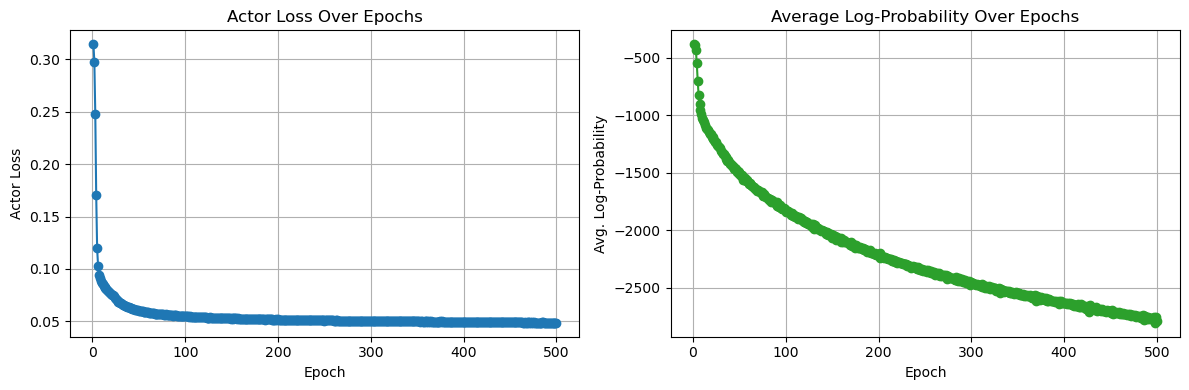

In [181]:
epochs_range = list(range(1, epochs+1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# 5.3.1 Actor Loss Over Epochs
ax1.plot(epochs_range, actor_loss_hist, marker='o')
ax1.set_title("Actor Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Actor Loss")
ax1.grid(True)

# 5.3.3 Log-Probability of Actions
ax2.plot(epochs_range, logprob_hist, marker='o', color='tab:green')
ax2.set_title("Average Log-Probability Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg. Log-Probability")
ax2.grid(True)

plt.tight_layout()
plt.savefig("RNN_FEATURE_actor_loss_and_logprob3.png", dpi=600)
plt.show()


### Trading Environment 

In [161]:
class MultiStockEnvironment:
    def __init__(self, data, window_size, initial_cash=10000):
        self.data = data
        self.window_size = window_size
        self.initial_cash = float(initial_cash)
        self.tickers = list(data.keys())
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.initial_cash
        self.holdings = {t: 0.0 for t in self.tickers}
        self.portfolio_values = [self.initial_cash]
        self.done = False

        return {
            t: np.column_stack([
                self.data[t]["norm"],
                self.data[t]["ema"],
                self.data[t]["rsi"],
                self.data[t]["macd"],
                self.data[t]["bb_upper"],
                self.data[t]["bb_lower"],
            ])[0:self.window_size]
            for t in self.tickers
        }

    def step(self, actions):
        # Liquidate negatives
        freed_cash = 0.0
        for t in self.tickers:
            if actions[t] < 0 and self.holdings[t] > 0:
                price = self.data[t]["raw"][self.t + self.window_size].item()
                freed_cash += self.holdings[t] * price
                self.holdings[t] = 0.0
        self.cash += freed_cash

        # Allocate positives
        pos_actions = {t: actions[t] for t in self.tickers if actions[t] > 0}
        total_pos = sum(pos_actions.values())
        if total_pos > 0 and self.cash > 0:
            for t, a in pos_actions.items():
                weight = a / total_pos
                price = self.data[t]["raw"][self.t + self.window_size].item()
                buy_amount = self.cash * weight
                self.holdings[t] += buy_amount / price
            self.cash = 0.0

        # Compute portfolio value
        pv = self.cash
        for t in self.tickers:
            price = self.data[t]["raw"][self.t + self.window_size].item()
            pv += self.holdings[t] * price
        self.portfolio_values.append(pv)

        # Advance time
        self.t += 1
        if self.t + self.window_size >= len(self.data[self.tickers[0]]["norm"]):
            self.done = True

        # Next state
        next_states = None
        if not self.done:
            next_states = {
                t: np.column_stack([
                    self.data[t]["norm"],
                    self.data[t]["ema"],
                    self.data[t]["rsi"],
                    self.data[t]["macd"],
                    self.data[t]["bb_upper"],
                    self.data[t]["bb_lower"],
                ])[self.t:self.t + self.window_size]
                for t in self.tickers
            }

        return next_states, pv, self.done, {}


### buy and hold

In [164]:
class BuyAndHoldEnvironment:
    def __init__(self, raw_prices, initial_cash=10000):
        self.raw_prices = raw_prices
        self.initial_cash = initial_cash
        self.portfolio_values = []

    def run(self, start_index=10):
        # stack into shape (T,5)
        prices = np.stack([self.raw_prices[t] for t in tickers], axis=1)
        # equal allocation
        alloc = self.initial_cash / len(tickers)
        init_p = prices[start_index]            # [5,]
        shares = alloc / init_p                 # [5,]
        # build PV curve
        for p in prices[start_index+1:]:
            self.portfolio_values.append((shares * p).sum())

### Simulate Agent with the trained MLP once 

In [167]:
env = MultiStockEnvironment(data, window_size=state_dim)
state_dict = env.reset()

day = 0
print("Starting multi-stock simulation...\n")

while not env.done:
    actions = {}
    trades = {}

    for t in tickers:
        win = state_dict[t]  # shape: (5, 6), already normalized
        st = torch.tensor(win, dtype=torch.float32).view(1, -1)  # flatten to (1, 30)

        a_tensor, _ = get_action(st, w1)
        a_val = a_tensor.item()
        actions[t] = a_val

        if a_val > 0 and env.holdings[t] == 0:
            trades[t] = "BUY"
        elif a_val < 0 and env.holdings[t] > 0:
            trades[t] = "SELL"
        else:
            trades[t] = "HOLD"

    # Step the environment
    next_states, port_val, done, _ = env.step(actions)

    # Log values
    cash = float(env.cash)
    prices = {t: float(data[t]["raw"][day + state_dim]) for t in tickers}
    held = {t: float(env.holdings[t]) for t in tickers}

    print(f"Day {day}: Cash = {cash:.2f}, Portfolio = {port_val:.2f}")
    for t in tickers:
        print(f"  {t:>6s} | Price = {prices[t]:6.2f} | "
              f"Action = {actions[t]:6.4f} | Trade = {trades[t]:>4s} | "
              f"Held = {held[t]:6.4f}")
    print("-" * 60)

    state_dict = next_states
    day += 1

print(f"\nDone. Final portfolio value: {env.portfolio_values[-1]:.2f}")


Starting multi-stock simulation...

Day 0: Cash = 0.00, Portfolio = 10000.00
    AAPL | Price =  78.73 | Action = 4.0493 | Trade =  BUY | Held = 20.4459
    MSFT | Price = 175.29 | Action = 5.8072 | Trade =  BUY | Held = 13.1709
   GOOGL | Price =  73.45 | Action = 4.9449 | Trade =  BUY | Held = 26.7655
    META | Price = 209.86 | Action = 4.5531 | Trade =  BUY | Held = 8.6252
    AMZN | Price = 102.51 | Action = 1.3273 | Trade =  BUY | Held = 5.1476
    TSLA | Price =  49.93 | Action = 1.2239 | Trade =  BUY | Held = 9.7448
    NVDA | Price =   6.33 | Action = 3.2481 | Trade =  BUY | Held = 204.0228
------------------------------------------------------------
Day 1: Cash = 0.00, Portfolio = 9991.66
    AAPL | Price =  77.66 | Action = 3.6549 | Trade = HOLD | Held = 20.4459
    MSFT | Price = 175.54 | Action = 4.2171 | Trade = HOLD | Held = 13.1709
   GOOGL | Price =  73.60 | Action = 7.3764 | Trade = HOLD | Held = 26.7655
    META | Price = 211.33 | Action = 5.1671 | Trade = HOLD | Hel

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_4818/944731319.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices = {t: float(data[t]["raw"][day + state_dim]) for t in tickers}


Day 26: Cash = 0.00, Portfolio = 6954.25
    AAPL | Price =  58.78 | Action = 5.6622 | Trade =  BUY | Held = 0.0000
    MSFT | Price = 129.62 | Action = 5.4802 | Trade = HOLD | Held = 2.0839
   GOOGL | Price =  53.39 | Action = 5.0894 | Trade = HOLD | Held = 41.6480
    META | Price = 145.33 | Action = 8.2829 | Trade = HOLD | Held = 13.1257
    AMZN | Price =  84.46 | Action = 5.1265 | Trade = HOLD | Held = 3.7341
    TSLA | Price =  29.67 | Action = 5.5262 | Trade = HOLD | Held = 24.5193
    NVDA | Price =   4.89 | Action = 2.1859 | Trade = HOLD | Held = 308.6620
------------------------------------------------------------
Day 27: Cash = 0.00, Portfolio = 7272.74
    AAPL | Price =  61.36 | Action = 4.6547 | Trade =  BUY | Held = 0.0000
    MSFT | Price = 140.29 | Action = 5.8447 | Trade = HOLD | Held = 2.0839
   GOOGL | Price =  55.64 | Action = 7.1404 | Trade = HOLD | Held = 41.6480
    META | Price = 148.72 | Action = 4.0380 | Trade = HOLD | Held = 13.1257
    AMZN | Price =  90.39

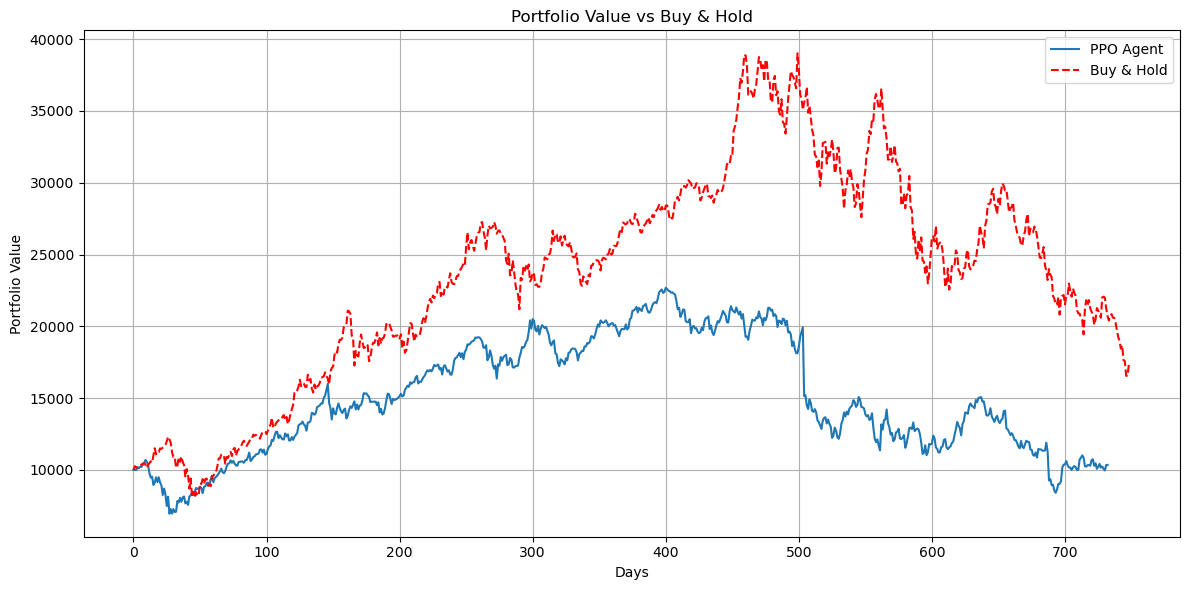


Final Results:
PPO final portfolio:       10350.67
Buy & Hold final portfolio:17379.21


In [169]:
bh_env = BuyAndHoldEnvironment(raw_prices)
bh_env.run(start_index=state_dim)

plt.figure(figsize=(12, 6))
plt.plot(env.portfolio_values, label='PPO Agent')
plt.plot(bh_env.portfolio_values, 'r--', label='Buy & Hold')
plt.title('Portfolio Value vs Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(f"PPO final portfolio:       {env.portfolio_values[-1]:.2f}")
print(f"Buy & Hold final portfolio:{bh_env.portfolio_values[-1]:.2f}")


### Run the Environment 50 times to get an average on how the MLP is performing

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_4818/3530055107.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("RNN_Feature

Running PPO (RNN Features) simulations...

Run  1/200 → Final Portfolio Value: 9219.05
Run  2/200 → Final Portfolio Value: 10855.35
Run  3/200 → Final Portfolio Value: 9276.71
Run  4/200 → Final Portfolio Value: 6768.60
Run  5/200 → Final Portfolio Value: 8475.44
Run  6/200 → Final Portfolio Value: 10962.11
Run  7/200 → Final Portfolio Value: 8933.65
Run  8/200 → Final Portfolio Value: 5949.89
Run  9/200 → Final Portfolio Value: 11860.20
Run 10/200 → Final Portfolio Value: 9539.03
Run 11/200 → Final Portfolio Value: 6743.62
Run 12/200 → Final Portfolio Value: 8905.22
Run 13/200 → Final Portfolio Value: 8032.73
Run 14/200 → Final Portfolio Value: 8083.11
Run 15/200 → Final Portfolio Value: 6552.60
Run 16/200 → Final Portfolio Value: 8140.25
Run 17/200 → Final Portfolio Value: 7906.26
Run 18/200 → Final Portfolio Value: 10383.88
Run 19/200 → Final Portfolio Value: 7796.23
Run 20/200 → Final Portfolio Value: 7854.11
Run 21/200 → Final Portfolio Value: 7838.23
Run 22/200 → Final Portfolio 

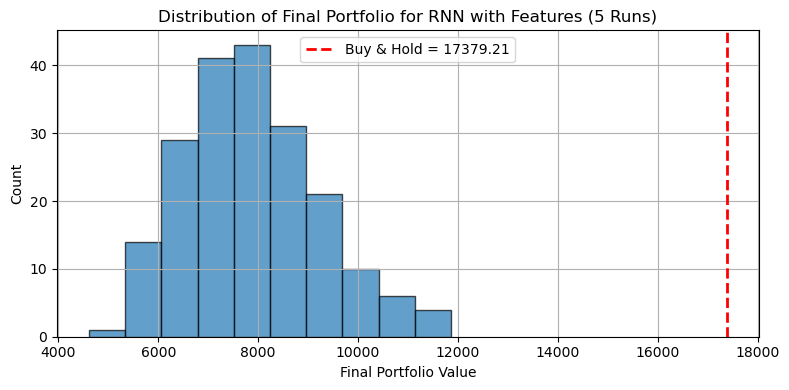

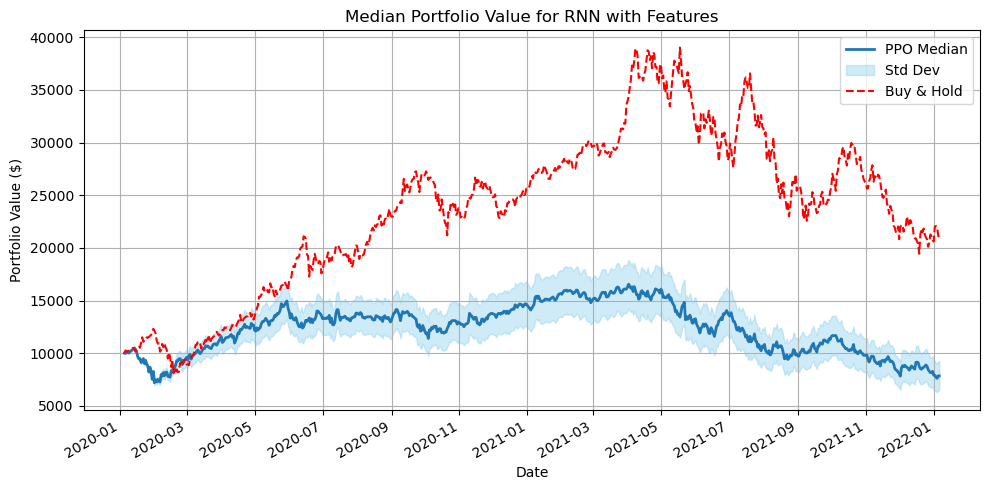

✓ Saved final portfolio values → RNN_Features/rnn_features_final_portfolios.csv
✓ Saved all portfolio trajectories → RNN_Features/rnn_features_all_trajectories.csv


In [96]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

n_runs = 200
final_portfolios = []
ppo_trajectories = []

# === Instantiate model and load weights ===
model = TunedRNNPolicy()
model.load_state_dict(torch.load("RNN_Features/RNN_Features_2.pth"))
model.eval()

# === Buy & Hold setup ===
bh_env = BuyAndHoldEnvironment(raw_prices)
bh_env.run(start_index=state_dim)
buy_hold_value = float(bh_env.portfolio_values[-1])
bh_curve = bh_env.portfolio_values
initial_cash = bh_env.initial_cash
bh_dates = pd.date_range(start="2020-01-01", periods=len(bh_curve))

# === Run PPO agent ===
print("Running PPO (RNN Features) simulations...\n")

for run in range(n_runs):
    env = MultiStockEnvironment(data, window_size=state_dim)
    state_dict = env.reset()
    done = False
    trajectory = [env.initial_cash]

    with torch.no_grad():
        while not done:
            actions = {}
            for t in tickers:
                win = state_dict[t]  # shape: (5, 6)
                st = torch.tensor(win, dtype=torch.float32).unsqueeze(0)  # (1, 5, 6)
                a = get_action(st, model)[0].item()
                actions[t] = a

            state_dict, pv, done, _ = env.step(actions)
            trajectory.append(pv)

    final_value = trajectory[-1]
    final_portfolios.append(final_value)
    ppo_trajectories.append(trajectory)
    print(f"Run {run+1:2d}/{n_runs} → Final Portfolio Value: {final_value:.2f}")

# === Statistics ===
mean_pf = np.mean(final_portfolios)
std_pf  = np.std(final_portfolios)
min_pf  = np.min(final_portfolios)
max_pf  = np.max(final_portfolios)
beats_bh = sum(p > buy_hold_value for p in final_portfolios)
beat_pct = beats_bh / n_runs * 100
agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_portfolios]
bh_return = (buy_hold_value / initial_cash - 1) * 100

print(f"\nSummary over {n_runs} runs:")
print(f"→ Mean Final Portfolio: {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Buy & Hold Final Portfolio: {buy_hold_value:.2f}")
print(f"→ PPO beat Buy & Hold in {beat_pct:.1f}% of runs ({beats_bh}/{n_runs})")
print(f"\n→ Avg Agent Return: {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"→ Buy & Hold Return: {bh_return:.2f}%")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_portfolios, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(buy_hold_value, color='r', linestyle='--', linewidth=2,
            label=f'Buy & Hold = {buy_hold_value:.2f}')
plt.title("Distribution of Final Portfolio for RNN with Features (5 Runs)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
os.makedirs("RNN_Features", exist_ok=True)
plt.savefig("RNN_Features/rnn_features_hist.png", dpi=600)
plt.show()

# === Median ± std trajectory plot ===
max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last_val = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last_val] * (max_len - len(ppo_trajectories[i]))

ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve    = np.std(ppo_array, axis=0)

x_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]
min_len = min(len(x_dates), len(median_curve), len(bh_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("Median Portfolio Value for RNN with Features")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("RNN_Features/rnn_features_median_std.png", dpi=600)
plt.show()

# === Save CSVs ===
pd.DataFrame({"final_portfolio_value": final_portfolios}) \
  .to_csv("RNN_Features/rnn_features_final_portfolios.csv", index=False)
pd.DataFrame(ppo_trajectories).T \
  .to_csv("RNN_Features/rnn_features_all_trajectories.csv", index=False)

print("✓ Saved final portfolio values → RNN_Features/rnn_features_final_portfolios.csv")
print("✓ Saved all portfolio trajectories → RNN_Features/rnn_features_all_trajectories.csv")


### test on unseen data 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



=== PPO on Unseen Data (CNN, 5 stocks) ===
Runs: 5
Final Portfolio → Mean 13432.54 ± 1552.76,  Min 11735.43, Max 15280.28
Buy & Hold Baseline: 15428.17
PPO beats Buy & Hold in 0/5 runs (0.0%)

Average Return: 34.33% ± 15.53%
Buy & Hold Return: 54.28%


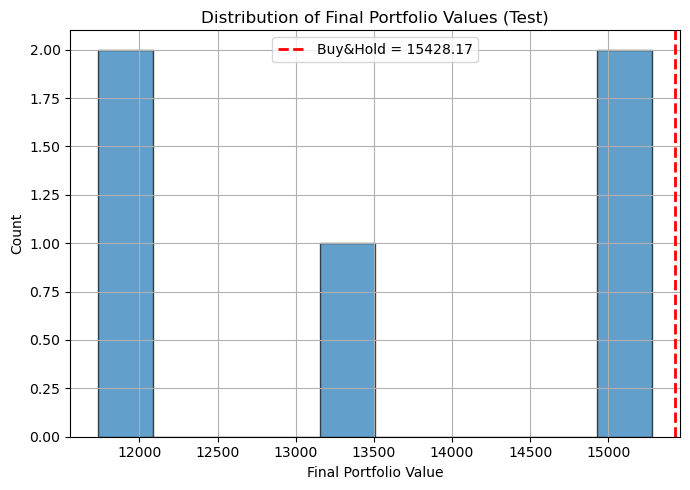

In [116]:
import copy

tickers = ["AAPL","MSFT","GOOGL","META","AMZN","TSLA","NVDA"]
start, end = "2023-01-01", "2024-01-01"

data_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end).copy()
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    ema = closes.ewm(span=5, adjust=False).mean().astype(np.float32)
    delta = closes.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    rsi = (100 - 100/(1 + rs)).astype(np.float32)

    ema12 = closes.ewm(span=12, adjust=False).mean()
    ema26 = closes.ewm(span=26, adjust=False).mean()
    macd = (ema12 - ema26).astype(np.float32)

    mbb = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2*mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2*mbb_sd).astype(np.float32)

    data_test[t] = {
        "dates": df.index,
        "raw": closes.values,
        "norm": norm.values,
        "ema": ema.values,
        "rsi": rsi.values,
        "macd": macd.values,
        "bb_upper": bb_upper.values,
        "bb_lower": bb_lower.values,
    }

# Clean + normalize
for t in tickers:
    feat_stack = np.column_stack([
        data_test[t]["norm"],
        data_test[t]["ema"],
        data_test[t]["rsi"],
        data_test[t]["macd"],
        data_test[t]["bb_upper"],
        data_test[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)

    for k in data_test[t]:
        data_test[t][k] = data_test[t][k][start_idx:]

    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data_test[t][feat]
        mu, sigma = arr.mean(), arr.std()
        data_test[t][feat] = (arr - mu) / sigma

# test for 50 runs
n_runs = 5
initial_cash = 10000
final_pf = []

for run in range(n_runs):
    env_test = MultiStockEnvironment(copy.deepcopy(data_test), window_size=state_dim, initial_cash=initial_cash)
    state_dict = env_test.reset()

    while not env_test.done:
        actions = {}
        for t in tickers:
            win = state_dict[t]  # shape: (state_dim, feat_dim)
            st = torch.tensor(win, dtype=torch.float32).view(1, -1)
            a_tensor, _ = get_action(st, w1)
            actions[t] = a_tensor.item()

        state_dict, port_val, done, _ = env_test.step(actions)

    final_pf.append(env_test.portfolio_values[-1])


bh = BuyAndHoldEnvironment({t: data_test[t]["raw"] for t in tickers}, initial_cash=initial_cash)
bh.run(start_index=state_dim)
bh_final = bh.portfolio_values[-1]

# plots
mean_pf = np.mean(final_pf)
std_pf  = np.std(final_pf)
min_pf  = np.min(final_pf)
max_pf  = np.max(final_pf)
beats   = sum(p > bh_final for p in final_pf)

returns = [(p / initial_cash - 1) * 100 for p in final_pf]
avg_return = np.mean(returns)
std_return = np.std(returns)
min_return = np.min(returns)
max_return = np.max(returns)
bh_return  = (bh_final / initial_cash - 1) * 100

print(f"\n=== PPO on Unseen Data (CNN, 5 stocks) ===")
print(f"Runs: {n_runs}")
print(f"Final Portfolio → Mean {mean_pf:.2f} ± {std_pf:.2f},  Min {min_pf:.2f}, Max {max_pf:.2f}")
print(f"Buy & Hold Baseline: {bh_final:.2f}")
print(f"PPO beats Buy & Hold in {beats}/{n_runs} runs ({beats/n_runs*100:.1f}%)")

print(f"\nAverage Return: {avg_return:.2f}% ± {std_return:.2f}%")
print(f"Buy & Hold Return: {bh_return:.2f}%")
 
plt.figure(figsize=(7,5))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2,
            label=f'Buy&Hold = {bh_final:.2f}')
plt.title("Distribution of Final Portfolio Values (Test)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



=== PPO on Unseen Data (RNN, Feature Stack) ===
Runs: 200
Final Portfolio → Mean 14465.04 ± 842.75,  Min 12652.68, Max 16464.00
Buy & Hold Baseline: 20393.83
PPO beats Buy & Hold in 0/200 runs (0.0%)

Average Return: 44.65% ± 8.43%
Buy & Hold Return: 103.94%


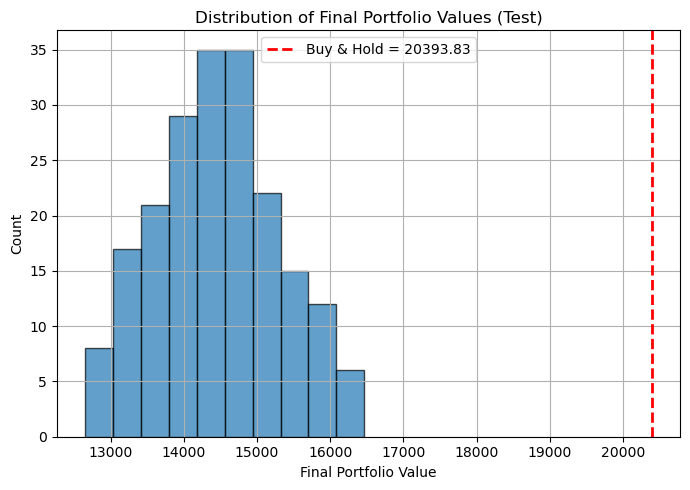

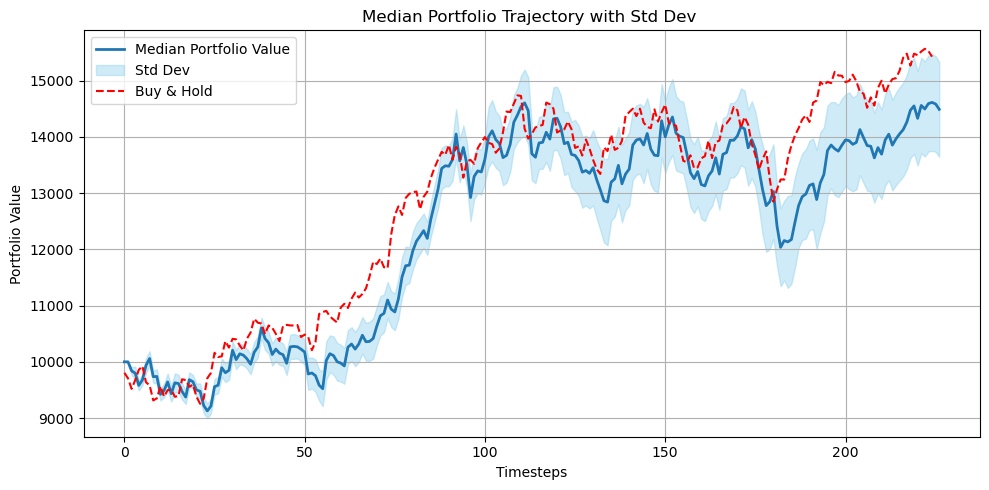

✓ Saved:
  → Final portfolios: FeatureStack_RNN_Results/final_portfolios.csv
  → Trajectories:     FeatureStack_RNN_Results/all_trajectories.csv
  → Histogram:        FeatureStack_RNN_Histogram.png
  → Median Plot:      FeatureStack_RNN_Median_Curve.png


In [171]:
import copy
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# === Setup ===
tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
start, end = "2023-01-01", "2024-01-01"
n_runs = 200
initial_cash = 10000
state_dim = 5

# === Download and preprocess test data ===
data_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end).copy()
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    ema = closes.ewm(span=5, adjust=False).mean().astype(np.float32)
    delta = closes.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    rsi = (100 - 100 / (1 + rs)).astype(np.float32)

    ema12 = closes.ewm(span=12, adjust=False).mean()
    ema26 = closes.ewm(span=26, adjust=False).mean()
    macd = (ema12 - ema26).astype(np.float32)

    mbb = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2 * mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2 * mbb_sd).astype(np.float32)

    data_test[t] = {
        "dates": df.index,
        "raw": closes.values,
        "norm": norm.values,
        "ema": ema.values,
        "rsi": rsi.values,
        "macd": macd.values,
        "bb_upper": bb_upper.values,
        "bb_lower": bb_lower.values,
    }

# === Clean + normalize ===
for t in tickers:
    feat_stack = np.column_stack([
        data_test[t]["norm"],
        data_test[t]["ema"],
        data_test[t]["rsi"],
        data_test[t]["macd"],
        data_test[t]["bb_upper"],
        data_test[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)

    for k in data_test[t]:
        data_test[t][k] = data_test[t][k][start_idx:]

    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data_test[t][feat]
        mu, sigma = arr.mean(), arr.std()
        data_test[t][feat] = (arr - mu) / sigma

# === PPO Evaluation ===
final_pf = []
trajectories = []

for run in range(n_runs):
    env_test = MultiStockEnvironment(copy.deepcopy(data_test), window_size=state_dim, initial_cash=initial_cash)
    state_dict = env_test.reset()
    trajectory = [env_test.initial_cash]

    while not env_test.done:
        actions = {}
        for t in tickers:
            win = state_dict[t]  # shape: (state_dim, feat_dim)
            st = torch.tensor(win, dtype=torch.float32).unsqueeze(0)  # [1, state_dim, feat_dim]
            a_tensor, _ = get_action(st, w1)
            actions[t] = a_tensor.item()

        state_dict, port_val, done, _ = env_test.step(actions)
        trajectory.append(port_val)

    final_pf.append(trajectory[-1])
    trajectories.append(trajectory)

# === Buy & Hold baseline ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_dates = pd.to_datetime(bh_data["dates"])
bh_final = bh_curve[-1]


# === Pad trajectories to same length ===
max_len = max(len(t) for t in trajectories)
for i in range(n_runs):
    last_val = trajectories[i][-1]
    trajectories[i] += [last_val] * (max_len - len(trajectories[i]))

trajectories_arr = np.array(trajectories)
median_curve = np.median(trajectories_arr, axis=0)
std_curve = np.std(trajectories_arr, axis=0)

# === Stats ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
beats = sum(p > bh_final for p in final_pf)

returns = [(p / initial_cash - 1) * 100 for p in final_pf]
avg_return = np.mean(returns)
std_return = np.std(returns)
bh_return = (bh_final / initial_cash - 1) * 100

print(f"\n=== PPO on Unseen Data (RNN, Feature Stack) ===")
print(f"Runs: {n_runs}")
print(f"Final Portfolio → Mean {mean_pf:.2f} ± {std_pf:.2f},  Min {min_pf:.2f}, Max {max_pf:.2f}")
print(f"Buy & Hold Baseline: {bh_final:.2f}")
print(f"PPO beats Buy & Hold in {beats}/{n_runs} runs ({beats/n_runs*100:.1f}%)")
print(f"\nAverage Return: {avg_return:.2f}% ± {std_return:.2f}%")
print(f"Buy & Hold Return: {bh_return:.2f}%")

# === Histogram ===
plt.figure(figsize=(7, 5))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2,
            label=f'Buy & Hold = {bh_final:.2f}')
plt.title("Distribution of Final Portfolio Values (Test)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("FeatureStack_RNN_Histogram1.png", dpi=600)
plt.show()

# === Median ± Std Dev plot ===
plt.figure(figsize=(10, 5))
plt.plot(median_curve, label='Median Portfolio Value', linewidth=2)
plt.fill_between(range(len(median_curve)),
                 median_curve - std_curve,
                 median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(bh.portfolio_values[:len(median_curve)], 'r--', label='Buy & Hold')
plt.title("Median Portfolio Trajectory with Std Dev ")
plt.xlabel("Timesteps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("FeatureStack_RNN_Median_Curve1.png", dpi=600)
plt.show()

# === Save Results ===
os.makedirs("FeatureStack_RNN_Results", exist_ok=True)
pd.DataFrame({"final_portfolio_value": final_pf}).to_csv("FeatureStack_RNN_Results/final_portfolios1.csv", index=False)
pd.DataFrame(trajectories_arr.T).to_csv("FeatureStack_RNN_Results/all_trajectories1.csv", index=False)

print("✓ Saved:")
print("  → Final portfolios: FeatureStack_RNN_Results/final_portfolios.csv")
print("  → Trajectories:     FeatureStack_RNN_Results/all_trajectories.csv")
print("  → Histogram:        FeatureStack_RNN_Histogram.png")
print("  → Median Plot:      FeatureStack_RNN_Median_Curve.png")
